In [180]:
 %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

n_samples, h, w = faces.images.shape

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [181]:
#show some sample pics

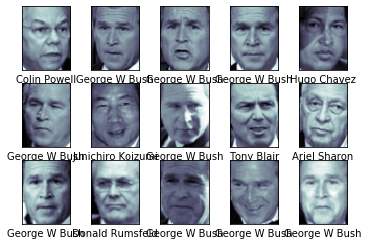

In [182]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [183]:
# split up training set and test set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=6)

print(Xtrain.shape)
print(Xtest.shape)

(1011, 2914)
(337, 2914)


In [184]:
#Use PCA to compress the image

In [185]:
from sklearn.decomposition import PCA
n_components = 150
print("extract top {} eigenfaces from {} face photos".format(n_components,Xtrain.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True, random_state=6).fit(Xtrain)

eigenfaces = pca.components_.reshape((n_components, h, w))


Xtrain_pca = pca.transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

extract top 150 eigenfaces from 1011 face photos


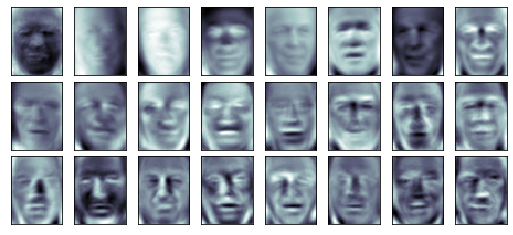

In [186]:
# Visualize principle component
fig,axes = plt.subplots(3,8, figsize=(9,4),
                   subplot_kw={'xticks':[],'yticks':[]},
                    gridspec_kw = dict(hspace=0.1, wspace=0.1))

for i,ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62,47),cmap='bone')
#pca.components_ is the selected 150 eigenvector of the covariance matirx of raw data

Text(0, 0.5, 'cumulative explained variance')

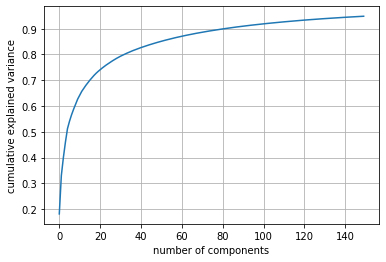

In [187]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [188]:
pca_150 = PCA(150).fit(faces.data)
components = pca_150.transform(faces.data)
projected = pca_150.inverse_transform(components)

In [189]:
components.shape

(1348, 150)

In [190]:
projected.shape

(1348, 2914)

Text(0, 0.5, '150-dim\n reconstruction')

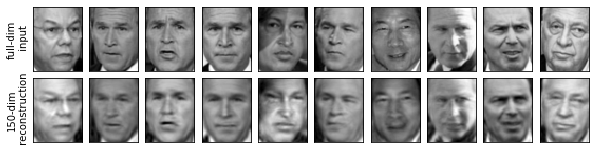

In [191]:
fig,ax = plt.subplots(2,10, figsize=(10,2.5),
                   subplot_kw={'xticks':[],'yticks':[]},
                    gridspec_kw = dict(hspace=0.1, wspace=0.1)
                       )
for i in range(10):
    ax[0,i].imshow(faces.data[i].reshape(62,47),cmap="binary_r")
    ax[1,i].imshow(projected[i].reshape(62,47),cmap="binary_r")
    
ax[0,0].set_ylabel("full-dim\n input")
ax[1,0].set_ylabel("150-dim\n reconstruction")

In [192]:
#The first row are the original pics and the second row are the pics after PCA treatment
#We could see that we kept most important features

In [193]:
#Try linear SVM as our baseline
from sklearn.svm import SVC 
svc = SVC(kernel='linear',C=10)
svc.fit(Xtrain_pca, ytrain)
yfit = svc.predict(Xtest_pca)

In [194]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.79      0.83      0.81        18
     Colin Powell       0.76      0.85      0.80        62
  Donald Rumsfeld       0.74      0.68      0.71        34
    George W Bush       0.83      0.83      0.83       134
Gerhard Schroeder       0.67      0.73      0.70        22
      Hugo Chavez       1.00      0.86      0.93        22
Junichiro Koizumi       1.00      1.00      1.00         9
       Tony Blair       0.78      0.69      0.74        36

         accuracy                           0.80       337
        macro avg       0.82      0.81      0.81       337
     weighted avg       0.81      0.80      0.80       337



In [206]:
from sklearn.model_selection import GridSearchCV
#choose the best 'C','gamma' and 'kernel'

#param_grid = {'kernel': ('linear', 'rbf','poly'),'C': [1, 5, 10, 50],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

param_grid = [
    {'kernel': ['linear'], 'C': [1, 5, 10, 50]},
    {'kernel': ['rbf'], 'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
    {'kernel': ['poly'], 'C': [1, 5, 10, 50], 'degree':[2,3,4], 'gamma': ['auto']}
]
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid,cv=10,n_jobs = -1)

%time grid.fit(Xtrain_pca, ytrain)
print(grid.best_estimator_)
print(grid.best_params_)

CPU times: user 1.15 s, sys: 90.3 ms, total: 1.24 s
Wall time: 1min 4s
SVC(C=5, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}


In [207]:
model = grid.best_estimator_
yfit = model.predict(Xtest_pca)

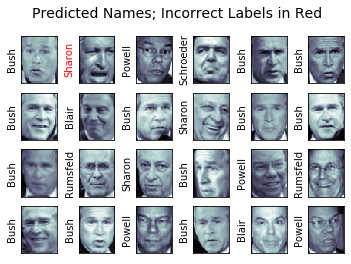

In [208]:
#Train the model with the model we selected above
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [209]:
#Produce performance report
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.83      0.83        18
     Colin Powell       0.82      0.94      0.87        62
  Donald Rumsfeld       0.82      0.82      0.82        34
    George W Bush       0.94      0.90      0.92       134
Gerhard Schroeder       0.76      0.86      0.81        22
      Hugo Chavez       1.00      0.86      0.93        22
Junichiro Koizumi       1.00      0.89      0.94         9
       Tony Blair       0.85      0.78      0.81        36

         accuracy                           0.88       337
        macro avg       0.88      0.86      0.87       337
     weighted avg       0.88      0.88      0.88       337



Text(91.68, 0.5, 'predicted label')

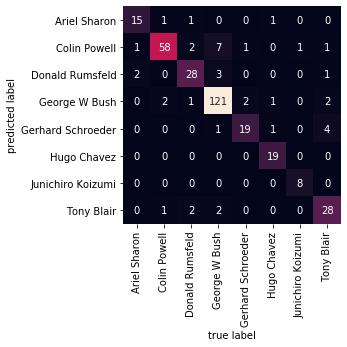

In [210]:
#Visualize the performance
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')